In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # 基础绘图库（什么都能画，但可能慢、复杂）
import seaborn as sns # 数据可视化专用库（专门用来快速画数据图）
from scipy.optimize import curve_fit


# 中文字体宋体，英文字体新罗马
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.serif'] = ['Times New Roman']
# 字体大小
plt.rcParams['font.size'] = 12  
# 正常显示负号
plt.rcParams['axes.unicode_minus'] = False

In [88]:
df1 = pd.read_csv('中间数据集\\多表_按品类\\花菜类.csv')
df2 = pd.read_csv('中间数据集\\多表_按品类\\花叶类.csv')
df3 = pd.read_csv('中间数据集\\多表_按品类\\茄类.csv')
df4 = pd.read_csv('中间数据集\\多表_按品类\\辣椒类.csv')
df5 = pd.read_csv('中间数据集\\多表_按品类\\食用菌.csv')
df6 = pd.read_csv('中间数据集\\多表_按品类\\水生根茎类.csv')

In [89]:
df1.columns

Index(['日期', '单品编码', '单品名称', '分类名称', '销量(千克)', '销售单价(元/千克)', '销售类型', '是否打折销售',
       '批发价格(元/千克)', '损耗率_品类'],
      dtype='object')

## ***计算成本加成定价***

In [90]:
def get_fee(df):

    df = df.drop(['单品名称', '分类名称', '单品编码', '销售类型', '是否打折销售'], axis=1)

    df['日期'] = pd.to_datetime(df['日期'])

    # 计算平均利润
    df['平均利润'] = (df['销售单价(元/千克)'] - df['批发价格(元/千克)']) * df['销量(千克)']
    
    # 计算平均利润率，避免负利润率
    df['平均利润率'] = (df['销售单价(元/千克)'] - df['批发价格(元/千克)']) / df['批发价格(元/千克)']
    
    # 将负利润率设置为0，以避免计算负数的加成率
    df['平均利润率'] = df['平均利润率'].apply(lambda x: max(x, 0))
    
    # 计算加成率，避免分母为0
    df['加成率'] = df['平均利润率'].apply(lambda x: x / (1 - x) if x < 1 else float('inf'))
    
    # 计算成本加成定价
    df['成本加成定价'] = df['批发价格(元/千克)'] * (1 + df['加成率'])
    
    # 如果成本加成定价大于批发价的1.75倍，则将成本加成定价设置为批发价的1.75倍
    max_allowed_price = df['批发价格(元/千克)'] * 1.75
    df['成本加成定价'] = df['成本加成定价'].where(df['成本加成定价'] <= max_allowed_price, max_allowed_price)

    df = df.drop(['平均利润', '平均利润率', '加成率'], axis=1)

    # 对时序数据进行聚合 resample
    df_final = df.resample('D', on='日期').agg({
        '销量(千克)': 'sum',
        '销售单价(元/千克)': 'mean',
        '批发价格(元/千克)': 'mean',
        '损耗率_品类': 'mean',    
        '成本加成定价': 'mean'
    })

    df_final['成本加成定价'].fillna(df_final['成本加成定价'].mean(), inplace=True)

    return df_final

In [91]:
df_1 = get_fee(df1)
df_1.to_csv("中间数据集\\按品类的日粒度时序数据集\\花菜类.csv")

df_2 = get_fee(df2)
df_2.to_csv("中间数据集\\按品类的日粒度时序数据集\\花叶类.csv")

df_3 = get_fee(df3)
df_3.to_csv("中间数据集\\按品类的日粒度时序数据集\\茄类.csv")

df_4 = get_fee(df4)
df_4.to_csv("中间数据集\\按品类的日粒度时序数据集\\辣椒类.csv")

df_5 = get_fee(df5)
df_5.to_csv("中间数据集\\按品类的日粒度时序数据集\\食用菌.csv")

df_6 = get_fee(df6)
df_6.to_csv("中间数据集\\按品类的日粒度时序数据集\\水生根茎类.csv")

C:\Users\jack\AppData\Local\Temp\ipykernel_12756\2393312797.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['成本加成定价'].fillna(df_final['成本加成定价'].mean(), inplace=True)
C:\Users\jack\AppData\Local\Temp\ipykernel_12756\2393312797.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

## ***探究数量关系***

In [92]:
# 按照箱线图规则清除异常值的函数
def remove_outliers(df, column):
    # 计算Q1和Q3
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # 计算IQR
    IQR = Q3 - Q1
    
    # 计算上下限
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 过滤掉异常值
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return filtered_df

# 使用函数清除异常值
df_1 = remove_outliers(df_1, '销量(千克)')
df_2 = remove_outliers(df_2, '销量(千克)')
df_3 = remove_outliers(df_3, '销量(千克)')
df_4 = remove_outliers(df_4, '销量(千克)')
df_5 = remove_outliers(df_5, '销量(千克)')
df_6 = remove_outliers(df_6, '销量(千克)')

df_1 = remove_outliers(df_1, '成本加成定价')
df_2 = remove_outliers(df_2, '成本加成定价')
df_3 = remove_outliers(df_3, '成本加成定价')
df_4 = remove_outliers(df_4, '成本加成定价')
df_5 = remove_outliers(df_5, '成本加成定价')
df_6 = remove_outliers(df_6, '成本加成定价')

In [93]:
# 一次函数
def func_1(x, a, b):
    return a * x  + b

def func_2(x, a, b):
    return a * np.exp(b * x)

params_quad1, _ = curve_fit(func_1, df_1['销量(千克)'], df_1['成本加成定价'])
df_1['预测值'] = func_1(df_1['销量(千克)'], *params_quad1)

params_quad2, _ = curve_fit(func_1, df_2['销量(千克)'], df_2['成本加成定价'])
df_2['预测值'] = func_1(df_2['销量(千克)'], *params_quad2)

params_quad3, _ = curve_fit(func_1, df_3['销量(千克)'], df_3['成本加成定价'])
df_3['预测值'] = func_1(df_3['销量(千克)'], *params_quad3)

params_quad4, _ = curve_fit(func_1, df_4['销量(千克)'], df_4['成本加成定价'])
df_4['预测值'] = func_1(df_4['销量(千克)'], *params_quad4)

params_quad5, _ = curve_fit(func_1, df_5['销量(千克)'], df_5['成本加成定价'])
df_5['预测值'] = func_1(df_5['销量(千克)'], *params_quad5)

params_quad6, _ = curve_fit(func_1, df_6['销量(千克)'], df_6['成本加成定价'])
df_6['预测值'] = func_1(df_6['销量(千克)'], *params_quad6)

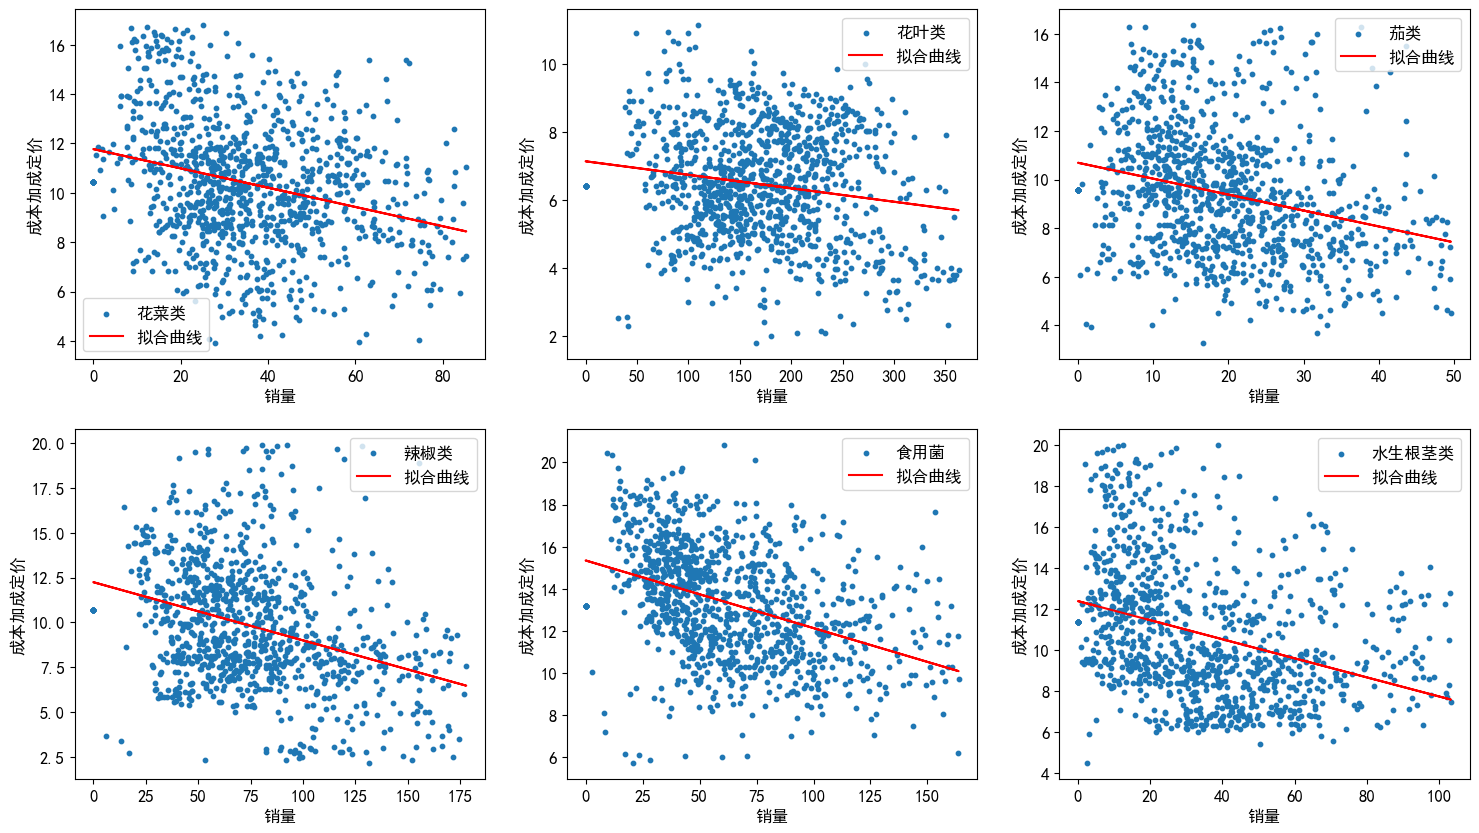

In [94]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# 不错
ax[0][0].scatter(df_1['销量(千克)'], df_1['成本加成定价'], s=10, label='花菜类')
ax[0][0].plot(df_1['销量(千克)'], df_1['预测值'], color='red', label='拟合曲线')

ax[0][1].scatter(df_2['销量(千克)'], df_2['成本加成定价'], s=10, label='花叶类')
ax[0][1].plot(df_2['销量(千克)'], df_2['预测值'], color='red', label='拟合曲线')

ax[0][2].scatter(df_3['销量(千克)'], df_3['成本加成定价'], s=10, label='茄类')
ax[0][2].plot(df_3['销量(千克)'], df_3['预测值'], color='red', label='拟合曲线')

ax[1][0].scatter(df_4['销量(千克)'], df_4['成本加成定价'], s=10, label='辣椒类')
ax[1][0].plot(df_4['销量(千克)'], df_4['预测值'], color='red', label='拟合曲线')

ax[1][1].scatter(df_5['销量(千克)'], df_5['成本加成定价'], s=10, label='食用菌')
ax[1][1].plot(df_5['销量(千克)'], df_5['预测值'], color='red', label='拟合曲线')

# 不错
ax[1][2].scatter(df_6['销量(千克)'], df_6['成本加成定价'], s=10, label='水生根茎类')
ax[1][2].plot(df_6['销量(千克)'], df_6['预测值'], color='red', label='拟合曲线')

for i in range(0, 2):
    for j in range(0, 3):
        ax[i][j].legend()
        ax[i][j].set_xlabel('销量')
        ax[i][j].set_ylabel('成本加成定价')

In [95]:
pd.DataFrame({'花菜类': params_quad1, 
        '花叶类': params_quad2, 
        '茄类': params_quad3, 
        '辣椒类': params_quad4, 
        '食用菌': params_quad5, 
        '水生根茎类': params_quad6
        }, index=['a', 'b'])

,花菜类,花叶类,茄类,辣椒类,食用菌,水生根茎类
a,-0.039077,-0.003963,-0.065555,-0.032450,-0.032116,-0.046523
b,11.773336,7.148345,10.689466,12.245995,15.347841,12.402717
